# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [183]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [184]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';');

In [185]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

#Demographic Data info:
print(f"Demographic Dataset's shapes:\nRows: {azdias.shape[0]}; Columns: {azdias.shape[1]} ")
print("\nFirst five rows of the Demographic Dataset")
azdias.head(10)


Demographic Dataset's shapes:
Rows: 891221; Columns: 85 

First five rows of the Demographic Dataset


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,2,1943,1.0,0,3,8.0,2.0,1.0,1.0,4.0,2.0,1,3,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0,0.0,0.0,2,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,4,0,12.0,0,2,2.0,1.0,1.0,1.0,2.0,1.0,1,10,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1,0.0,0.0,1,4,0.0,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,5,1964,9.0,0,1,5.0,2.0,1.0,1.0,1.0,1.0,1,8,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0,0.0,0.0,1,1,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,6,1974,3.0,1,3,10.0,3.0,1.0,1.0,10.0,5.0,1,11,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3,0.0,0.0,2,6,16.0,1.0,0.0,3.0,NaN,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,1,1975,12.0,1,2,4.0,1.0,1.0,1.0,3.0,2.0,1,15,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3,0.0,0.0,2,4,17.0,1.0,0.0,4.0,6.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [186]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [187]:
#Features summary info:
print(f"Features summary Dataset's shapes:\nRows: {feat_info.shape[0]}; Columns: {feat_info.shape[1]} ")
print("\nFirst five rows of the Features summary Dataset")
feat_info.head(10)

Features summary Dataset's shapes:
Rows: 85; Columns: 4 

First five rows of the Features summary Dataset


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [188]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [189]:
#Total number of Nulls in Demographic Dataset:
print(f"\nTotal of Nulls: {azdias.isnull().sum().sum()}")


Total of Nulls: 4896838


In [190]:
# Identify missing or unknown data values and convert them to NaNs.
for i in range (len(feat_info)):
    missing_or_unknown = feat_info.loc[i , 'missing_or_unknown'].strip('[]').split(',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[i]['attribute']: missing_or_unknown}, np.nan)

In [191]:
print('Total number of missing values after onverting unknow and missing item to NaNs:  {}'.format(azdias.isnull().sum().sum()))

Total number of missing values after onverting unknow and missing item to NaNs:  8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [192]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_col = azdias.isnull().sum()
missing_col


AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

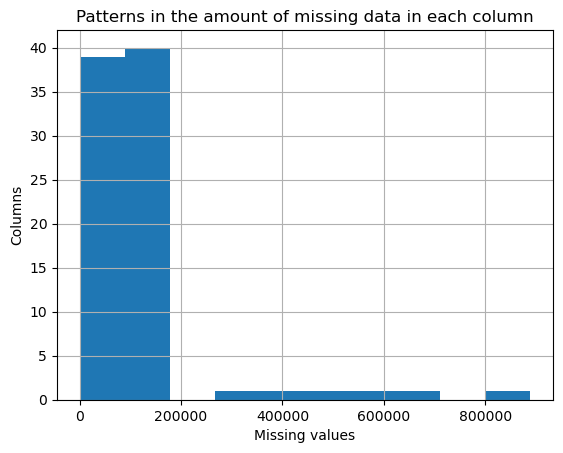

In [193]:
# Investigate patterns in the amount of missing data in each column.
missing_col.hist()
plt.title('Patterns in the amount of missing data in each column')
plt.xlabel('Missing values')
plt.ylabel('Columns');


In [194]:
# Details about outliner columns
missing_col_outlier = missing_col[missing_col>200000]
outlier_col = missing_col_outlier.index
print(f"Outliner columns with more than 20.000 missing values:\n{missing_col_outlier}\n")
print(f"Missing percentage per outliner column:\n{((missing_col_outlier/len(azdias))*100)}%")


Outliner columns with more than 20.000 missing values:
AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64

Missing percentage per outliner column:
AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64%


In [195]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop(missing_col_outlier.index, axis=1, inplace=True)
# Dropping the corresponding outliner attributes in feat_info dataframe
feat_info_clean = feat_info[~feat_info.attribute.isin(missing_col_outlier.index)]

In [196]:
outlier_col

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

In [197]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   888340 non-null  float64
 1   ANREDE_KZ              891221 non-null  int64  
 2   CJT_GESAMTTYP          886367 non-null  float64
 3   FINANZ_MINIMALIST      891221 non-null  int64  
 4   FINANZ_SPARER          891221 non-null  int64  
 5   FINANZ_VORSORGER       891221 non-null  int64  
 6   FINANZ_ANLEGER         891221 non-null  int64  
 7   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 8   FINANZ_HAUSBAUER       891221 non-null  int64  
 9   FINANZTYP              891221 non-null  int64  
 10  GFK_URLAUBERTYP        886367 non-null  float64
 11  GREEN_AVANTGARDE       891221 non-null  int64  
 12  HEALTH_TYP             780025 non-null  float64
 13  LP_LEBENSPHASE_FEIN    793589 non-null  float64
 14  LP_LEBENSPHASE_GROB    796649 non-nu

#### Discussion 1.1.2: Assess Missing Data in Each Column

It is observed from both the histogram missing percentages that the 6 colums below of the demographic dataset have significantly large percentage of missing values (34.8% - 99.8% missing):

- AGER_TYP
- GEBURTSJAHR
- TITEL_KZ
- ALTER_HH
- KK_KUNDENTYP
- KBA05_BAUMAX

Therefore, these columns need to be removed.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

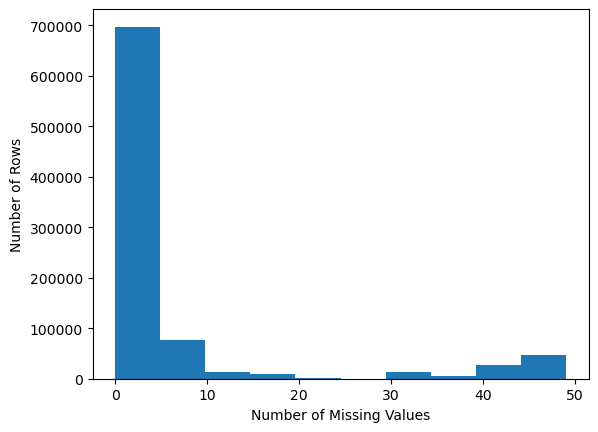

In [198]:
# How much data is missing in each row of the dataset?
missing_row = azdias.isnull().sum(axis=1)
plt.hist(missing_row)
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')
plt.show()

In [199]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missing_threshold = 30

# Divide into 2 subsets:

azdias_missing_below = azdias[missing_row < missing_threshold]
azdias_missing_above = azdias[missing_row >= missing_threshold]

In [200]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def create_plot(column):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True)
    fig.set_figwidth(15)
    ax1.set_title('Missing below the threshold')
    sns.countplot(x = column, data = azdias_missing_below, ax = ax1)

    ax2.set_title('Missing above the threshold')
    sns.countplot(x = column, data = azdias_missing_above,ax=ax2)
    
    plt.show()


In [201]:
azdias_missing_below.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


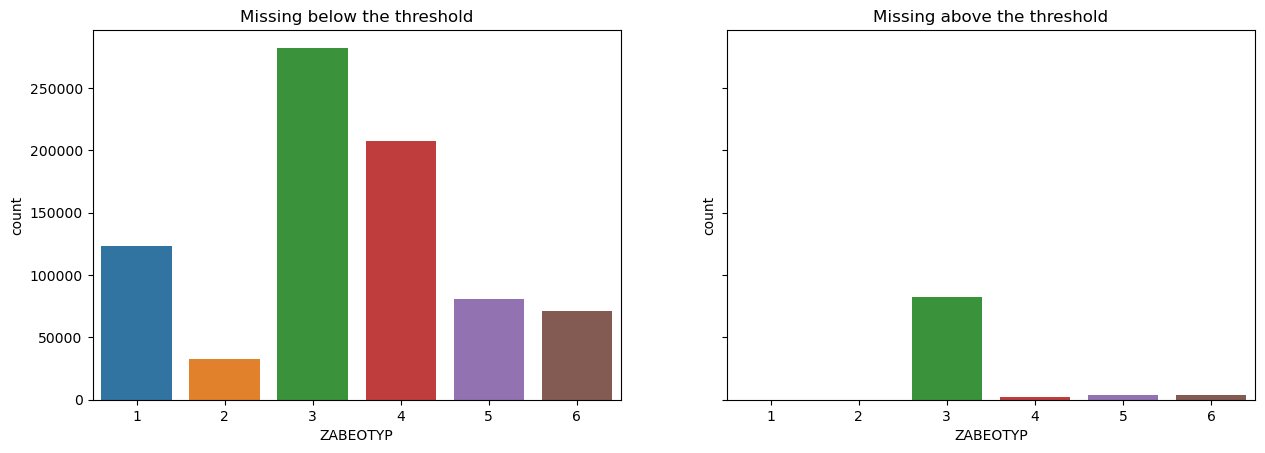

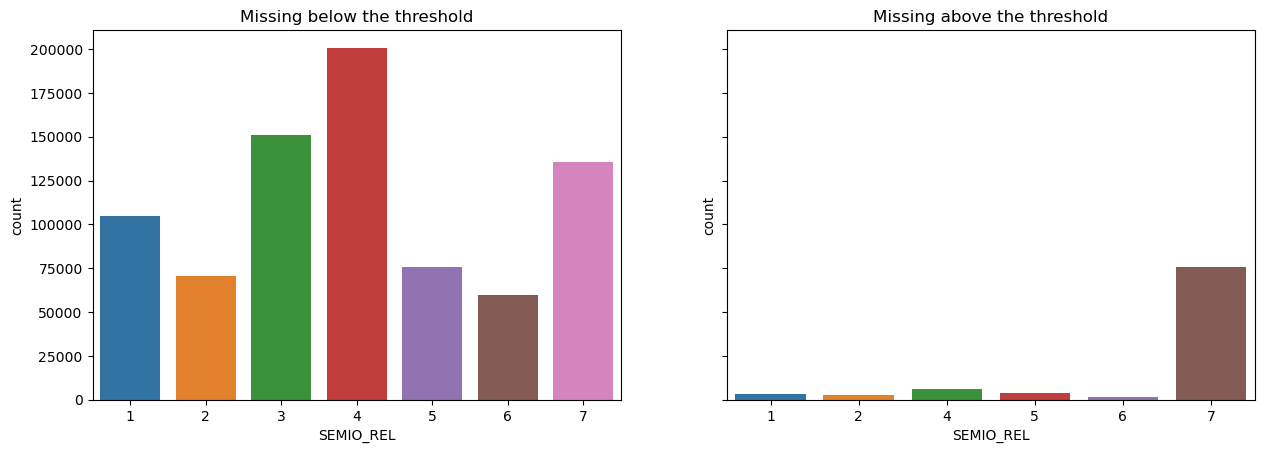

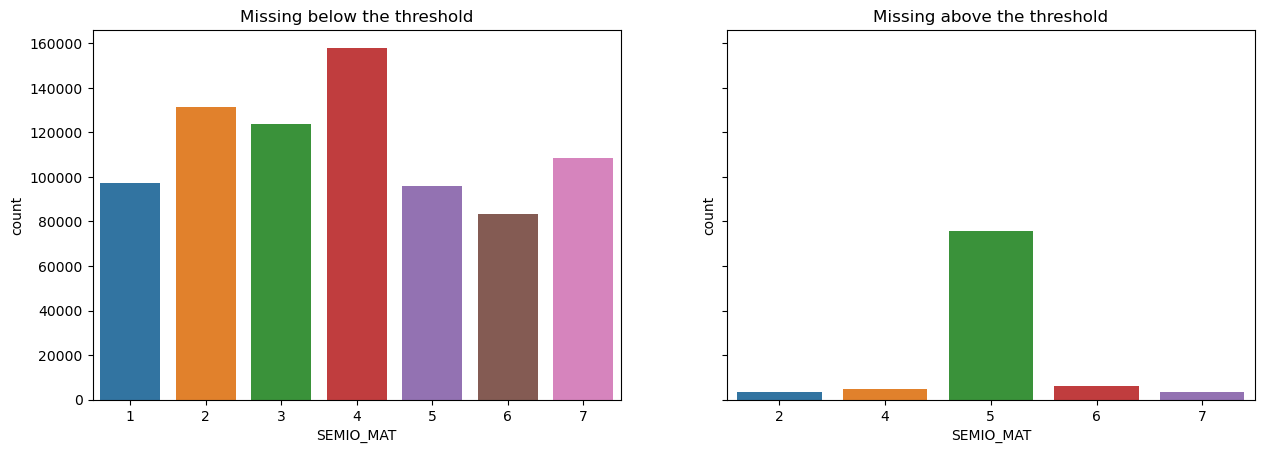

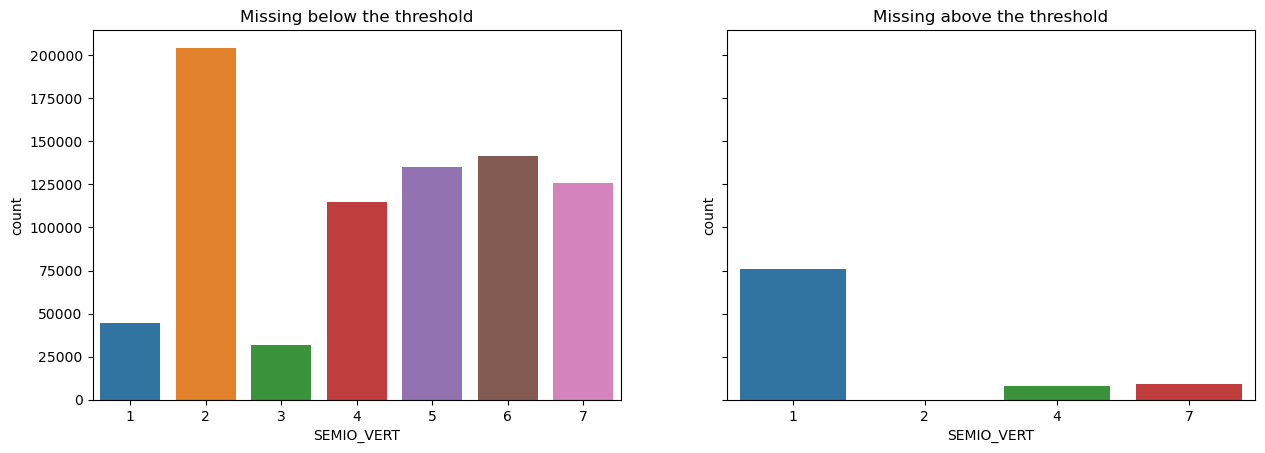

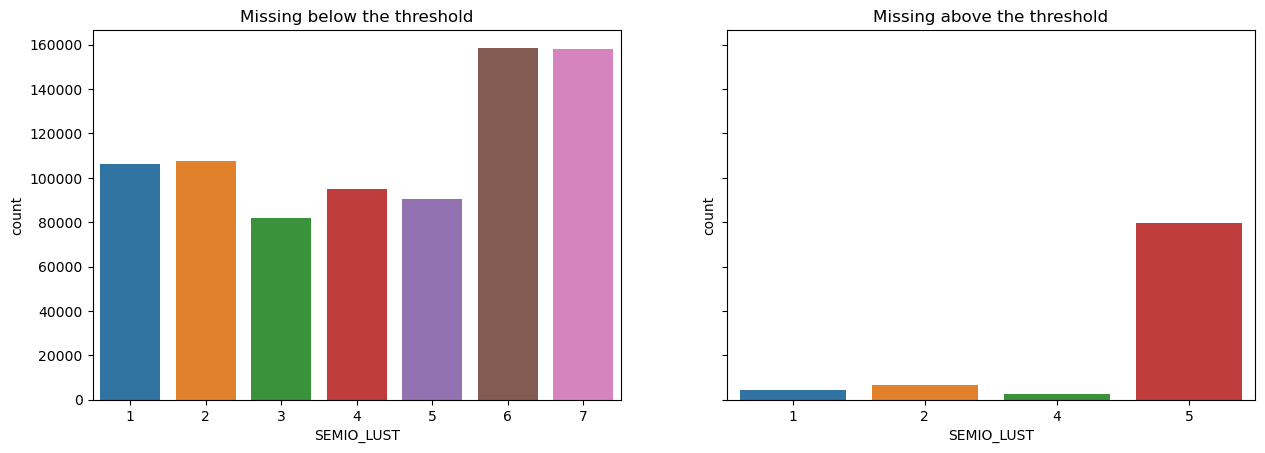

In [202]:
# 5 columns with the least nulls:
lowest_null_columns = list(azdias.isna().sum().sort_values().index[:5])

for i in lowest_null_columns:
    create_plot(i)

#### Discussion 1.1.3: Assess Missing Data in Each Row

We can see that the data with lots of missing values are qualitatively different from data with few or no missing values. As we compare it over the first five columns that are not missing data.

So, we need to note that those data are special.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [203]:
# How many features are there of each data type?
feat_info_clean['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [204]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

catgorical_feat_info = feat_info_clean[feat_info_clean['type']=="categorical"]

binary_cat = []
multi_lvl_cat = []

for i in catgorical_feat_info.attribute:
    if azdias_missing_below[i].nunique() == 2:
        # Binary categorical 
        binary_cat.append(i)
    else:
        # Multi-level categorical
        multi_lvl_cat.append(i)

In [205]:
# Recheck:
print(f"Binary categoricals ({len(binary_cat)}): {binary_cat}")
print(f"Multi-level categoricals ({len(multi_lvl_cat)}): {multi_lvl_cat}")

Binary categoricals (5): ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Multi-level categoricals (13): ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [206]:
 # Inspecting Binary categorical variables' values:
azdias_bin = azdias_missing_below[binary_cat]

for column in azdias_bin.columns:
    unique_values = azdias_bin[column].unique()
    print(f"Unique values in '{column}': {unique_values}")

Unique values in 'ANREDE_KZ': [2 1]
Unique values in 'GREEN_AVANTGARDE': [0 1]
Unique values in 'SOHO_KZ': [1. 0.]
Unique values in 'VERS_TYP': [ 2.  1. nan]
Unique values in 'OST_WEST_KZ': ['W' 'O']


In [207]:
# Subset's shape before reencoding:
azdias_missing_below.shape

(798061, 79)

In [208]:
# Re-encode categorical variable(s) to be kept in the analysis.
# 1. Drop multi-level features:
for feature in multi_lvl_cat:
    azdias_missing_below = azdias_missing_below.drop(feature, axis=1)

In [209]:
# 2. Re-encode the binaries:
azdias_missing_below['OST_WEST_KZ'].replace({'W':0,'O':1}, inplace=True)
azdias_missing_below['OST_WEST_KZ'] = azdias_missing_below['OST_WEST_KZ'].astype('int')

In [210]:
# Subset's shape after reencoding:
azdias_missing_below.shape

(798061, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features

- Among the categorical features: There're 5 binary features ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'], with only one is non-numeric. The rest are multilevel features.

- Following the suggestions, I dropped 13 multilevel categorical features, kept the numeric-binary categorical features. And re-encoded the non-numeric binary: 'OST_WEST_KZ'


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### PRAEGENDE_JUGENDJAHRE  

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)

- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)  

### CAMEO_INTL_2015

German CAMEO: Wealth / Life Stage Typology, mapped to international code

- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown 

In [211]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# "PRAEGENDE_JUGENDJAHRE" unique entries:
print(azdias_missing_below['PRAEGENDE_JUGENDJAHRE'].value_counts())
# "PRAEGENDE_JUGENDJAHRE" first 10 rows:
azdias_missing_below['PRAEGENDE_JUGENDJAHRE'].head(10)

14.0    182983
8.0     141630
10.0     85808
5.0      84691
3.0      53845
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      20678
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64


1     14.0
2     15.0
3      8.0
4      8.0
5      3.0
6     10.0
7      8.0
8     11.0
9     15.0
10     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [212]:
# Engineering 2 new features: 'MOVEMENT' and 'DECADE'

movement_dict = {1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
decade_dict = {1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}

azdias_missing_below["MOVEMENT"] = azdias_missing_below['PRAEGENDE_JUGENDJAHRE']
azdias_missing_below["DECADE"] = azdias_missing_below['PRAEGENDE_JUGENDJAHRE']

In [213]:
azdias_missing_below["DECADE"].replace(decade_dict,inplace=True)
azdias_missing_below["MOVEMENT"].replace(movement_dict,inplace=True)

In [214]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print(azdias_missing_below['CAMEO_INTL_2015'].value_counts())
# "PRAEGENDE_JUGENDJAHRE" first 10 rows:
azdias_missing_below['CAMEO_INTL_2015'].head(10)

51    133694
41     92336
24     91157
14     62884
43     56672
54     45391
25     39626
22     33154
23     26750
13     26335
45     26132
55     23955
52     20542
31     19023
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64


1     51
2     24
3     12
4     43
5     54
6     22
7     14
8     13
9     15
10    51
Name: CAMEO_INTL_2015, dtype: object

In [215]:
# Dictionaries for WEALTH and LIFE STAGE variables:

wealth_dic={'11':1,'12':1,'13':1,'14':1,'15':1,
            '21':2,'22':2,'23':2,'24':2,'25':2,
            '31':3,'32':3,'33':3,'34':3,'35':3,
            '41':4,'42':4,'43':4,'44':4,'45':4,
            '51':5,'52':5,'53':5,'54':5,'55':5
            }
life_dic={'11':1,'12':2,'13':3,'14':4,'15':5,
            '21':1,'22':2,'23':3,'24':4,'25':5,
            '31':1,'32':2,'33':4,'34':4,'35':5,
            '41':1,'42':2,'43':3,'44':4,'45':5,
            '51':1,'52':2,'53':3,'54':4,'55':5
            }

# Engineering two new features 'WEALTH' and 'LIFE_STAGE':
azdias_missing_below["WEALTH"]=azdias_missing_below.CAMEO_INTL_2015
azdias_missing_below["LIFE_STAGE"]=azdias_missing_below.CAMEO_INTL_2015
# Replace with new variables
azdias_missing_below["WEALTH"].replace(wealth_dic,inplace=True)
azdias_missing_below["LIFE_STAGE"].replace(life_dic,inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Replaced 2 mixed features `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015` by new features: `MOVEMENT`, `DECADE` and `WEALTH`, `LIFE_STAGE`, the 4 remaining mixed features are dropped in later step. 

1. With PRAEGENDE_JUGENDJAHRE, I created two new variables `MOVEMENT` and `DECADE`. `MOVEMENT` has two binary variables, '1' for 'mainstream' and '0' for to 'avantgarde'.

While with `DECADE`, I treated it as interval variable, with every decade correspond to a numeric value.

2. With `CAMEO_INTL_2015`, I replaced the values by new features as `WEALTH` and `LIFE_STAGE` into two new ordinal variables, each of these features contains only five groups of Wealth and Life Stage Typology

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [216]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [217]:
# Show all mixed type features:
feat_info_mixed = feat_info_clean[feat_info_clean['type'] == 'mixed']
feat_info_mixed

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [218]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
# Drop All those mixed features, including PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 since they can be replaced by new features:
for col in feat_info_mixed.attribute:
    azdias_missing_below.drop(col,axis=1,inplace=True)
azdias_missing_below.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,1.0,6.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,0.0,6.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,1.0,4.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,1.0,4.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,1.0,2.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [219]:
outlier_col

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

In [220]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for i in range (len(feat_info)):
        missing_or_unknown = feat_info.loc[i , 'missing_or_unknown'].strip('[]').split(',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df = df.replace({feat_info.iloc[i]['attribute']: missing_or_unknown}, np.nan)
    
    
    # remove selected columns and rows, ...

    # 1. Remove outliners columns with large missing percentage:
    df.drop(outlier_col, axis = 1, inplace=True)
    # Dropping the corresponding outliner attributes in feat_info dataframe
    feat_info_clean = feat_info[~feat_info.attribute.isin(missing_col_outlier.index)]

    # 2. Remove rows with large amount of missing values:
    missing_row = df.isnull().sum(axis=1)
    missing_threshold = 30

    # Divide into 2 subsets:
    azdias_missing_below = df[missing_row < missing_threshold]
    azdias_missing_above = df[missing_row >= missing_threshold]
    #clean_df = azdias_missing_below
    
    # select, re-encode, and engineer column values.
    catgorical_feat_info = feat_info_clean[feat_info_clean['type']=="categorical"]

    binary_cat = []
    multi_lvl_cat = []

    for i in catgorical_feat_info.attribute:
        if azdias_missing_below[i].nunique() == 2:
            # Binary categorical 
            binary_cat.append(i)
        else:
            # Multi-level categorical
            multi_lvl_cat.append(i)

    # Drop multi-level features:
    for feature in multi_lvl_cat:
        azdias_missing_below = azdias_missing_below.drop(feature, axis=1)

    # Re-encode the binaries:
    azdias_missing_below['OST_WEST_KZ'].replace({'W':0,'O':1}, inplace=True)
    azdias_missing_below['OST_WEST_KZ'] = azdias_missing_below['OST_WEST_KZ'].astype('int')

    # Engineering 2 new features: 'MOVEMENT' and 'DECADE'

    movement_dict = {1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
    decade_dict = {1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}

    azdias_missing_below["MOVEMENT"] = azdias_missing_below['PRAEGENDE_JUGENDJAHRE']
    azdias_missing_below["DECADE"] = azdias_missing_below['PRAEGENDE_JUGENDJAHRE']
    
    azdias_missing_below["DECADE"].replace(decade_dict,inplace=True)
    azdias_missing_below["MOVEMENT"].replace(movement_dict,inplace=True)

    # Dictionaries for WEALTH and LIFE STAGE variables:

    wealth_dic={'11':1,'12':1,'13':1,'14':1,'15':1,
                '21':2,'22':2,'23':2,'24':2,'25':2,
                '31':3,'32':3,'33':3,'34':3,'35':3,
                '41':4,'42':4,'43':4,'44':4,'45':4,
                '51':5,'52':5,'53':5,'54':5,'55':5
                }
    life_dic={'11':1,'12':2,'13':3,'14':4,'15':5,
                '21':1,'22':2,'23':3,'24':4,'25':5,
                '31':1,'32':2,'33':4,'34':4,'35':5,
                '41':1,'42':2,'43':3,'44':4,'45':5,
                '51':1,'52':2,'53':3,'54':4,'55':5
                }

    # Engineering two new features 'WEALTH' and 'LIFE_STAGE':
    azdias_missing_below["WEALTH"]=azdias_missing_below.CAMEO_INTL_2015
    azdias_missing_below["LIFE_STAGE"]=azdias_missing_below.CAMEO_INTL_2015
    # Replace with new variables
    azdias_missing_below["WEALTH"].replace(wealth_dic,inplace=True)
    azdias_missing_below["LIFE_STAGE"].replace(life_dic,inplace=True)

    # Drop All those mixed features, including PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 since they can be replaced by new features:
    for col in feat_info_mixed.attribute:
        azdias_missing_below.drop(col,axis=1,inplace=True)
    azdias_missing_below.head()

    # Return the cleaned dataframe.
    azdias_cleaned = azdias_missing_below
    return azdias_cleaned


In [221]:
# Test the clean function:
# 1. Intital clean subset:
azdias_missing_below.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798061 entries, 1 to 891220
Data columns (total 64 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   795258 non-null  float64
 1   ANREDE_KZ              798061 non-null  int64  
 2   FINANZ_MINIMALIST      798061 non-null  int64  
 3   FINANZ_SPARER          798061 non-null  int64  
 4   FINANZ_VORSORGER       798061 non-null  int64  
 5   FINANZ_ANLEGER         798061 non-null  int64  
 6   FINANZ_UNAUFFAELLIGER  798061 non-null  int64  
 7   FINANZ_HAUSBAUER       798061 non-null  int64  
 8   GREEN_AVANTGARDE       798061 non-null  int64  
 9   HEALTH_TYP             761340 non-null  float64
 10  RETOURTYP_BK_S         793316 non-null  float64
 11  SEMIO_SOZ              798061 non-null  int64  
 12  SEMIO_FAM              798061 non-null  int64  
 13  SEMIO_REL              798061 non-null  int64  
 14  SEMIO_MAT              798061 non-nu

In [222]:
# 2. Subset returned by the cleaning function:
azdias_test = pd.read_csv("Udacity_AZDIAS_Subset.csv",sep=';')
azdias_cleaned_df = clean_data(azdias_test)

In [223]:
azdias_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798061 entries, 1 to 891220
Data columns (total 64 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   795258 non-null  float64
 1   ANREDE_KZ              798061 non-null  int64  
 2   FINANZ_MINIMALIST      798061 non-null  int64  
 3   FINANZ_SPARER          798061 non-null  int64  
 4   FINANZ_VORSORGER       798061 non-null  int64  
 5   FINANZ_ANLEGER         798061 non-null  int64  
 6   FINANZ_UNAUFFAELLIGER  798061 non-null  int64  
 7   FINANZ_HAUSBAUER       798061 non-null  int64  
 8   GREEN_AVANTGARDE       798061 non-null  int64  
 9   HEALTH_TYP             761340 non-null  float64
 10  RETOURTYP_BK_S         793316 non-null  float64
 11  SEMIO_SOZ              798061 non-null  int64  
 12  SEMIO_FAM              798061 non-null  int64  
 13  SEMIO_REL              798061 non-null  int64  
 14  SEMIO_MAT              798061 non-nu

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [224]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
print(f"Number of NaN values: {azdias_cleaned_df.isna().sum().sum()}")

Number of NaN values: 763261


In [225]:
# Fill NaNs 
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer to your data
imputer_model = imputer.fit(azdias_cleaned_df)
imputer_data = imputer.transform(azdias_cleaned_df)

# Replace missing values
azdias_cleaned_df = pd.DataFrame(imputer_data, columns=azdias_cleaned_df.columns)

In [226]:
print(f"Number of NaN values: {azdias_cleaned_df.isna().sum().sum()}")

Number of NaN values: 0


In [227]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler_model = scaler.fit(azdias_cleaned_df)
features_scaled_df = scaler.transform(azdias_cleaned_df)
features_scaled_df = pd.DataFrame(features_scaled_df, columns=azdias_cleaned_df.columns)


### Discussion 2.1: Apply Feature Scaling

The NaN values were filled by he most frequent value in each column using Imputer. Before StandardScaler to scale all the features.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [228]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
pca = pca.fit(features_scaled_df)

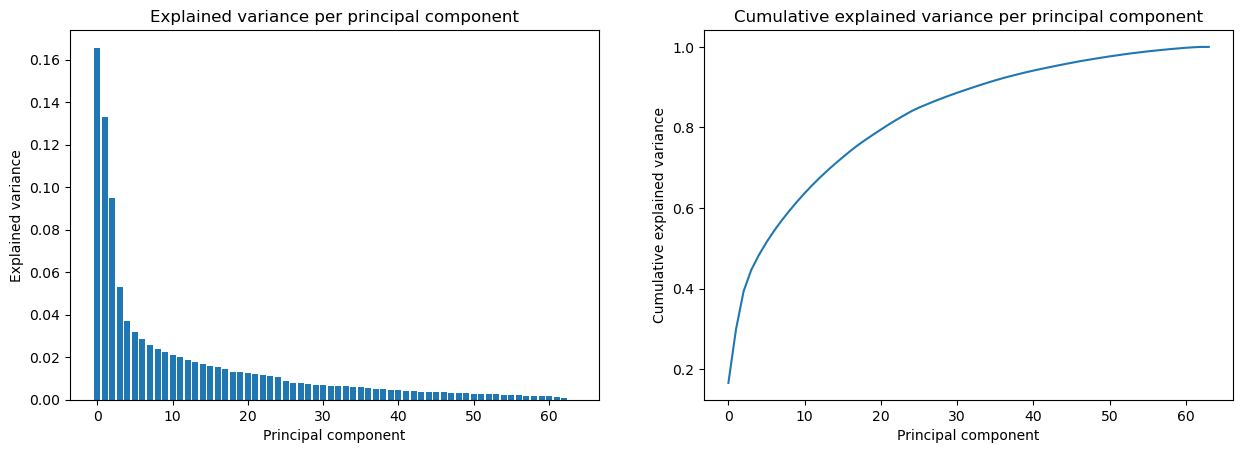

In [229]:
# Investigate the variance accounted for by each principal component.
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)

ax1.set_title("Explained variance per principal component")
ax1.set_xlabel("Principal component")
ax1.set_ylabel("Explained variance")
num_components = np.arange(len(pca.explained_variance_ratio_))
values = pca.explained_variance_ratio_
ax1.bar(num_components, values)

ax2.set_title('Missing above the threshold')
cum_vals = np.cumsum(values)
ax2.plot(num_components, cum_vals)
ax2.set_xlabel("Principal component")
ax2.set_ylabel("Cumulative explained variance")
ax2.set_title("Cumulative explained variance per principal component")

plt.show()

In [230]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_50 = PCA(n_components=50)
pca_50_model = pca_50.fit(features_scaled_df)
data_PCA = pca_50.transform(features_scaled_df)

### Discussion 2.2: Perform Dimensionality Reduction

Since many multi-level categorical features and other features had been dropped during the cleaning process before. Retaining 50 components seems suitable as it gets cumulative variance explained the original data at around 90%. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [231]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def PCA_weights(df,pca,n):
    weights_df = pd.DataFrame(pca.components_,columns =df.columns).iloc[n]
    weights_df.sort_values(ascending=False, inplace=True)
    return weights_df

In [232]:
pca_weight_0 = PCA_weights(features_scaled_df, pca_50, 0)
print (pca_weight_0)

PLZ8_ANTG3               0.225390
PLZ8_ANTG4               0.216910
WEALTH                   0.204635
HH_EINKOMMEN_SCORE       0.202164
ORTSGR_KLS9              0.196829
EWDICHTE                 0.194720
FINANZ_HAUSBAUER         0.159550
KBA05_ANTG4              0.154015
PLZ8_ANTG2               0.153722
FINANZ_SPARER            0.152955
ARBEIT                   0.142619
KBA05_ANTG3              0.136725
ANZ_HAUSHALTE_AKTIV      0.136078
RELAT_AB                 0.134981
SEMIO_PFLICHT            0.121031
SEMIO_REL                0.118460
DECADE                   0.112104
MOVEMENT                 0.110164
SEMIO_RAT                0.099461
SEMIO_TRADV              0.093589
SEMIO_MAT                0.082355
FINANZ_UNAUFFAELLIGER    0.080957
SEMIO_FAM                0.080932
SEMIO_KULT               0.075421
FINANZ_ANLEGER           0.074955
REGIOTYP                 0.060318
OST_WEST_KZ              0.053677
SEMIO_SOZ                0.043268
PLZ8_HHZ                 0.042277
HEALTH_TYP    

In [233]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_1 = PCA_weights(features_scaled_df, pca_50, 1)
print (pca_weight_1)


ALTERSKATEGORIE_GROB     0.256358
SEMIO_ERL                0.229968
FINANZ_VORSORGER         0.229326
SEMIO_LUST               0.180165
RETOURTYP_BK_S           0.161897
FINANZ_HAUSBAUER         0.121713
SEMIO_KRIT               0.117841
SEMIO_KAEM               0.116398
W_KEIT_KIND_HH           0.114715
PLZ8_ANTG3               0.098250
EWDICHTE                 0.097768
ORTSGR_KLS9              0.096447
PLZ8_ANTG4               0.096109
ANREDE_KZ                0.093121
WEALTH                   0.079110
KBA05_ANTG4              0.075132
SEMIO_DOM                0.074464
ARBEIT                   0.071728
RELAT_AB                 0.069212
PLZ8_ANTG2               0.068068
ANZ_HAUSHALTE_AKTIV      0.066392
HH_EINKOMMEN_SCORE       0.061837
FINANZ_MINIMALIST        0.059534
WOHNDAUER_2008           0.058509
KBA05_ANTG3              0.050482
VERS_TYP                 0.032121
ANZ_HH_TITEL             0.032047
OST_WEST_KZ              0.027435
MOVEMENT                 0.018311
PLZ8_HHZ      

In [234]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_2 = PCA_weights(features_scaled_df, pca_50, 2)
print (pca_weight_2)

SEMIO_VERT               0.344673
SEMIO_SOZ                0.261922
SEMIO_FAM                0.248825
SEMIO_KULT               0.233926
FINANZ_MINIMALIST        0.154542
RETOURTYP_BK_S           0.108973
FINANZ_VORSORGER         0.101729
W_KEIT_KIND_HH           0.085065
ALTERSKATEGORIE_GROB     0.079639
SEMIO_REL                0.067655
SEMIO_LUST               0.064462
SEMIO_MAT                0.055659
ORTSGR_KLS9              0.050230
EWDICHTE                 0.049439
PLZ8_ANTG4               0.049152
PLZ8_ANTG3               0.048355
GREEN_AVANTGARDE         0.047124
ARBEIT                   0.037323
RELAT_AB                 0.034329
WOHNDAUER_2008           0.032658
PLZ8_ANTG2               0.032639
WEALTH                   0.030159
KBA05_ANTG4              0.029956
ANZ_HAUSHALTE_AKTIV      0.026776
OST_WEST_KZ              0.016295
ANZ_HH_TITEL             0.013900
KBA05_ANTG3              0.011868
ANZ_TITEL                0.009633
PLZ8_HHZ                 0.005631
VERS_TYP      

### Discussion 2.3: Interpret Principal Components

1. First Principal Component:
- Positive weights
    - PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region)
    - PLZ8_ANTG4 (Number of 10+ family houses in the PLZ8 region)
    - WEALTH (German CAMEO: Wealth)
- Negative weights
    - FINANZ_MINIMALIST (Financial typology: low financial interest)
    - MOBI_REGIO (Movement patterns)
    - PLZ8_ANTG1 (Number of 1-2 family houses in the PLZ8 region)
2. Second Principal Component
- Positive weights
    - ALTERSKATEGORIE_GROB (Estimated age based on given name analysis)
    - FINANZ_VORSORGER (Financial typology: be prepared)
    - SEMIO_ERL (Personality typology, event-oriented)
- Negative weights
    - FINANZ_SPARER (Financial typology: money-saver)
    - DECADE (Dominating movement of person's youth - decade)
    - SEMIO_REL (Personality typology, religious)
3. Third Principal Component
- Positive weights
    - SEMIO_VERT (Personality typology: dreamful)
    - SEMIO_SOZ (Personality typology: socially-minded)
    - SEMIO_FAM (Personality typology: family-minded)
- Negative weights
    - SEMIO_DOM (Personality typology: dominant-minded)
    - SEMIO_KAEM (Personality typology: combative attitude)
    - ANREDE_KZ (Gender)

We can observe that the first component is about income and number of family houses. Also, we suggest that the second component was about financial typologies and age. And for the third component, it tells more about personality typologies.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [235]:
from sklearn.cluster import KMeans

num_clusters=np.arange(2,21)
scores=[]
# Over a number of different cluster counts...
for k in num_clusters:
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=k)
    model = kmeans.fit(data_PCA)
    # compute the average within-cluster distances.
    score = np.abs(model.score(data_PCA))
    scores.append(score)
    
    

c:\Users\latong\AppData\Local\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\latong\AppData\Local\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\latong\AppData\Local\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\latong\AppData\Local\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1

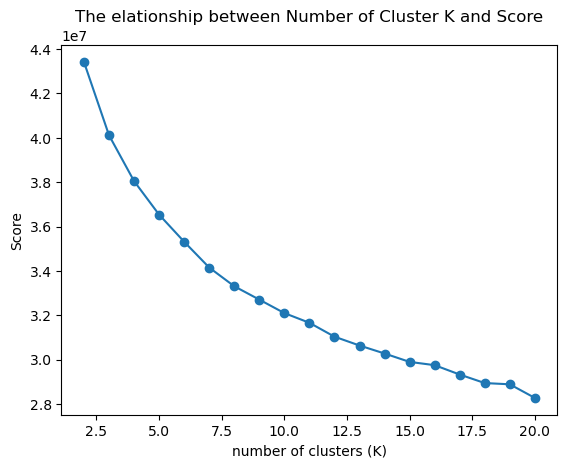

In [236]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(num_clusters,scores, marker='o')
plt.xlabel('number of clusters (K)')
plt.ylabel('Score')
plt.title("The elationship between Number of Cluster K and Score")
plt.show()


In [261]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 11)
cluster_model = kmeans.fit(data_PCA)
data_pred = kmeans.predict(data_PCA)


c:\Users\latong\AppData\Local\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Discussion 3.1: Apply Clustering to General Population

Based on the plot above. It looks like the elbow correponds to k = 11. Thus, I choose 11 as the number of clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [262]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';');

In [263]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned = clean_data(customers)

# Fit the imputer to your data
customers_imputer = imputer.transform(customers_cleaned)

# Replace missing values
customers_cleaned = pd.DataFrame(customers_imputer, columns=customers_cleaned.columns)

# Scaling:
customers_scaled = scaler.transform(customers_cleaned)

# PCA transformation
customers_PCA = pca_50.transform(customers_scaled)

#Cluster prediction:
customers_pred = kmeans.predict(customers_PCA)


c:\Users\latong\AppData\Local\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

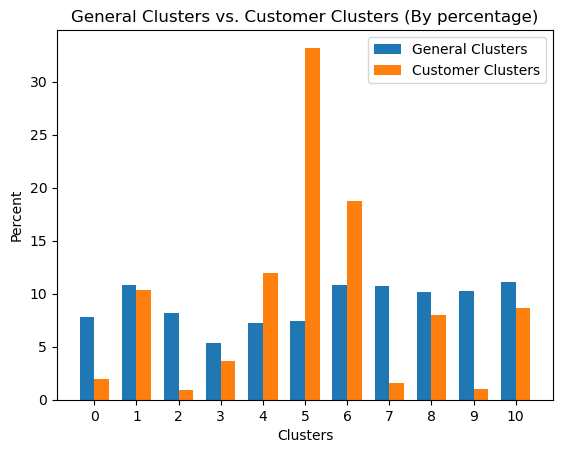

In [271]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Calculate the frequency of each unique value in each array
unique_values_general, count_general = np.unique(data_pred, return_counts=True)
unique_values_customers, count_customers = np.unique(customers_pred, return_counts=True)

# Calculate the percentage of each unique value in each array
percentage1 = count_general / len(data_pred) * 100
percentage2 = count_customers / len(customers_pred) * 100

# Set the width of the bars
bar_width = 0.35

# Set the x positions of the bars
x_pos1 = np.arange(len(unique_values_general))
x_pos2 = x_pos1 + bar_width

# Create a bar plot
plt.bar(x_pos1, percentage1, width=bar_width, label='General Clusters')
plt.bar(x_pos2, percentage2, width=bar_width, label='Customer Clusters')

# Add labels and title to the plot
plt.xlabel('Clusters')
plt.ylabel('Percent')
plt.title('General Clusters vs. Customer Clusters (By percentage)')

# Add x-axis tick labels
plt.xticks(x_pos1 + bar_width/2, unique_values_general)

plt.legend(loc='upper right')

# Show the plot
plt.show()

In [267]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_5 = scaler.inverse_transform(pca_50.inverse_transform(model.cluster_centers_[5]).reshape(1,-1))

In [268]:
over_represented = pd.Series(data = centroid_5.reshape(-1), index=customers_cleaned.columns)

In [269]:
over_represented

ALTERSKATEGORIE_GROB        1.412953
ANREDE_KZ                   2.020665
FINANZ_MINIMALIST           1.203097
FINANZ_SPARER               4.212329
FINANZ_VORSORGER            2.147631
FINANZ_ANLEGER              4.059905
FINANZ_UNAUFFAELLIGER       3.659157
FINANZ_HAUSBAUER            4.158543
GREEN_AVANTGARDE            0.020832
HEALTH_TYP                  2.155003
RETOURTYP_BK_S              2.423574
SEMIO_SOZ                   3.194836
SEMIO_FAM                   4.159743
SEMIO_REL                   5.678419
SEMIO_MAT                   5.067514
SEMIO_VERT                  2.271221
SEMIO_LUST                  2.588100
SEMIO_ERL                   3.996783
SEMIO_KULT                  4.462715
SEMIO_RAT                   6.668617
SEMIO_KRIT                  5.488815
SEMIO_DOM                   6.482800
SEMIO_KAEM                  6.237682
SEMIO_PFLICHT               6.275476
SEMIO_TRADV                 6.476116
SOHO_KZ                    -0.000005
VERS_TYP                    1.443341
A

In [270]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_9 = scaler.inverse_transform(pca_50.inverse_transform(model.cluster_centers_[9]).reshape(1,-1))
under_represented = pd.Series(data = centroid_9.reshape(-1), index=customers_cleaned.columns)
under_represented

ALTERSKATEGORIE_GROB        1.945679
ANREDE_KZ                   0.987996
FINANZ_MINIMALIST           3.444839
FINANZ_SPARER               3.823868
FINANZ_VORSORGER            2.318864
FINANZ_ANLEGER              3.225332
FINANZ_UNAUFFAELLIGER       4.133901
FINANZ_HAUSBAUER            1.954206
GREEN_AVANTGARDE            0.985230
HEALTH_TYP                  2.120916
RETOURTYP_BK_S              2.624020
SEMIO_SOZ                   6.536630
SEMIO_FAM                   6.486708
SEMIO_REL                   6.031056
SEMIO_MAT                   4.851788
SEMIO_VERT                  6.339136
SEMIO_LUST                  3.207665
SEMIO_ERL                   2.405932
SEMIO_KULT                  6.514290
SEMIO_RAT                   4.079724
SEMIO_KRIT                  2.357052
SEMIO_DOM                   2.731009
SEMIO_KAEM                  2.164835
SEMIO_PFLICHT               5.373214
SEMIO_TRADV                 4.713464
SOHO_KZ                     0.000003
VERS_TYP                    1.450439
A

### Discussion 3.3: Compare Customer Data to Demographics Data

From the anaylsis above, it can be seen that:

Cluster 5 is over-represented in the customer data, as it depicts the highest proprotion in the Customer Data (33%) but has considerably lower percentage in Population Data (13%):

|     | FEATURE              | VALUE         | DETAIL                                                                                              |
| --- | -------              | -----         | ------                                                                                              |
| 1   |    ANREDE_KZ         |   2.020665    |    Gender: Female                                                                                   |
| 2   |    FINANZ_ANLEGER    |   4.059905    |    Financial typology (investor): Low                                                               |
| 3   |    KONSUMNAEHE       |   2.103333    |    building is located in a 250 x 250m grid cell that includes at least one RA1-consumption cell    |
| 4   | ALTERSKATEGORIE_GROB |   1.412953    |    Estimated age based on given name analysis: <30 years old                                        |
| 5   |    FINANZ_SPARER     |   4.212329    |    Financial typology (money-saver): Low                                                            |

It seems that persons come from the cluster seem to be the target audience of the company: Female, <30 years olds, doesn't seems to keen on saving nor investing, and their building is located in a 250 x 250m grid cell that includes at least one RA1-consumption cell.

Cluster 9 is under-represented in the customer data, since it has the lowest proportion in Customer Data (<2%) but has considerably high percentage in Population Data (12%):

|     | FEATURE                      | VALUE         | DETAIL                                                              |
| --- | -------                      | -----         | ------                                                              |
| 1   |    ANREDE_KZ                 |   0.987996    |    Gender: Male                                                     |
| 2   |    FINANZ_SPARER             |   3.823868    |    Financial typology (investor): Low                               |
| 3   |    HH_EINKOMMEN_SCORE        |   2.854220    |    Estimated household net income: High                             |
| 4   |    ALTERSKATEGORIE_GROB      |   1.945679    |    Estimated age based on given name analysis: 30 - 45 years old    |
| 5   |    REGIOTYP                  |   3.528660    |    Neighborhood typology: Middle class                              |

So, the segment who are Male 30-45 years old, have high income but don't seem like investing, typically live in middle class neighborhood - isn't likely to be the primary target audience of the company.